# SPY Forecasting

## Import Statements

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from sklearn.preprocessing import LabelEncoder
from fredapi import Fred

## Feature Engineering

We engineered a comprehensive set of features to capture different aspects of market behavior, ensuring a well-rounded dataset for modeling. These features include:

- Daily Trading Data
- Seasonality Features
- Technical Indicators
- Macroeconomic Variables
- Market Conditions

This diverse range of features was designed to provide a holistic view of the market, enabling the model to analyze patterns from multiple perspectives.

### Daily Trading Data

We started by extracting the daily trading data, which provides a fundamental view of the market's day-to-day behavior. This foundational set of features captures the core aspects of trading activity, serving as a baseline for more advanced feature engineering and analysis.

- Open: The price at which the asset began trading on a given day.
- High: The highest price reached during the trading session.
- Low: The lowest price observed during the session.
- Close: The final price at the end of the trading day.
- Volume: The total number of shares or contracts traded throughout the day.
- Daily Return: The percentage change in the closing price from the previous day, offering insight into daily price fluctuations.


In [28]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
spy_data = spy_data[features]

spy_data['Daily_Return'] = spy_data['Close'].pct_change()
# Flatten the index
spy_data.columns = spy_data.columns.get_level_values(0)  
spy_data.reset_index(drop=True, inplace=True)


[*********************100%***********************]  1 of 1 completed


In [29]:
print(spy_data)

Price        Open        High         Low       Close     Volume       Date  \
0      112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1      113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2      113.519997  113.989998  113.430000  113.709999  116074400 2010-01-06   
3      113.500000  114.330002  113.180000  114.190002  131091100 2010-01-07   
4      113.889999  114.620003  113.660004  114.570000  126402800 2010-01-08   
...           ...         ...         ...         ...        ...        ...   
3517   473.859985  475.380005  471.700012  473.649994   67126600 2023-12-22   
3518   474.070007  476.579987  473.989990  475.649994   55387000 2023-12-26   
3519   475.440002  476.660004  474.890015  476.510010   68000300 2023-12-27   
3520   476.880005  477.549988  476.260010  476.690002   77158100 2023-12-28   
3521   476.489990  477.029999  473.299988  475.309998  122234100 2023-12-29   

Price  Daily_Return  
0               NaN  
1      

### Seasonality

We then incorporated seasonality features to capture the cyclical patterns and temporal influences often observed in financial markets. These seasonality features provide the model with critical information about recurring patterns, enabling it to better understand and predict market trends influenced by time-based factors.

- Day of Week: Encodes the specific day of the week (e.g., Monday as 0, Tuesday as 1, etc.), allowing the model to detect weekly trading patterns.
- Month: Represents the month of the year (e.g., January as 1, February as 2, etc.), capturing seasonal effects on market behavior.

In [30]:
# Ensure the Date column in spy_data is in datetime format
spy_data['Date'] = pd.to_datetime(spy_data['Date'])

# Create new features
spy_data['Day_of_Week'] = spy_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
spy_data['Month'] = spy_data['Date'].dt.month  # January=1, December=12


#### Technical Indicators

To enhance our model's ability to detect and interpret market trends and momentum, we incorporated a wide range of technical indicators. These indicators are widely used in technical analysis to provide insights into price movements, volatility, and market dynamics. The features include:

1. Trend Indicators
Trend indicators highlight the direction and strength of price movements over time:

- EMA20 (20-day Exponential Moving Average):
Gives more weight to recent prices to track short-term trends.
- MA5 and MA10 (5-day and 10-day Simple Moving Averages):
Capture quick price trends.
- CCI (Commodity Channel Index):
Measures price deviation from its average over a 20-day period.

2. Momentum Indicators
Momentum indicators measure the speed and magnitude of price movements, helping identify overbought or oversold conditions and reversals:

- MACD (Moving Average Convergence Divergence):
Includes the MACD line, Signal line, and MACD histogram to capture momentum shifts and trend reversals.
- MTM6 and MTM12 (6-month and 12-month Momentum):
Measures price changes over 6-month and 12-month periods.
- ROC (Rate of Change):
Tracks the percentage change in price over a 10-day period.
- SMI (Stochastic Momentum Index):
Identifies the relative position of the current price within the high-low range over 14 days.

3. Volatility Indicators
Volatility indicators measure the extent of price fluctuations, providing insights into market uncertainty and risk:

- ATR (Average True Range):
Captures the average range of price movements over a 14-day period.
- Bollinger Bands:
Includes the upper and lower bands around a 20-day moving average to measure price volatility.

4. Volume-Based Indicators
Volume-based indicators combine price and trading volume to assess the strength of market movements:

- WVAD (Williams's Variable Accumulation/Distribution):
Combines price and volume to evaluate the flow of funds into or out of a security.

In [31]:
# Trend Indicators:

# EMA20 (20-day Exponential Moving Average)
spy_data['EMA20'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

# MA5 and MA10 (5-day and 10-day Simple Moving Averages)
spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
spy_data['MA10'] = spy_data['Close'].rolling(window=10).mean()

# CCI (Commodity Channel Index)
typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Close']) / 3
mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))


# Momentum Indicators:

#MACD
spy_data['EMA12'] = spy_data['Close'].ewm(span=12, adjust=False).mean()
spy_data['EMA26'] = spy_data['Close'].ewm(span=26, adjust=False).mean()
spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

# MTM6 and MTM12 (6-month and 12-month Momentum)
spy_data['MTM6'] = spy_data['Close'].pct_change(periods=126)  # Approx. 6 months
spy_data['MTM12'] = spy_data['Close'].pct_change(periods=252)  # Approx. 12 months

# ROC (Rate of Change)
spy_data['ROC'] = spy_data['Close'].pct_change(periods=10) * 100  # 10-day rate of change

# SMI (Stochastic Momentum Index)
low_min = spy_data['Low'].rolling(window=14).min()
high_max = spy_data['High'].rolling(window=14).max()
spy_data['SMI'] = 100 * ((spy_data['Close'] - low_min) / (high_max - low_min))


# Volume Indicators:

# ATR (Average True Range)
high_low = spy_data['High'] - spy_data['Low']
high_close = np.abs(spy_data['High'] - spy_data['Close'].shift())
low_close = np.abs(spy_data['Low'] - spy_data['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
spy_data['ATR'] = true_range.rolling(window=14).mean()

# Bollinger Bands (BOLL)
spy_data['20_MA'] = spy_data['Close'].rolling(window=20).mean()
spy_data['20_STD'] = spy_data['Close'].rolling(window=20).std()
spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])


# Volatility Indicators:

# WVAD (Williams's Variable Accumulation/Distribution)
spy_data['WVAD'] = ((spy_data['Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

print(spy_data.head())

Price        Open        High         Low       Close     Volume       Date  \
0      112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1      113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2      113.519997  113.989998  113.430000  113.709999  116074400 2010-01-06   
3      113.500000  114.330002  113.180000  114.190002  131091100 2010-01-07   
4      113.889999  114.620003  113.660004  114.570000  126402800 2010-01-08   

Price  Daily_Return  Day_of_Week  Month       EMA20  ...  MTM6  MTM12  ROC  \
0               NaN            0      1  113.330002  ...   NaN    NaN  NaN   
1          0.002647            1      1  113.358573  ...   NaN    NaN  NaN   
2          0.000704            2      1  113.392042  ...   NaN    NaN  NaN   
3          0.004221            3      1  113.468038  ...   NaN    NaN  NaN   
4          0.003328            4      1  113.572987  ...   NaN    NaN  NaN   

Price  SMI  ATR  20_MA  20_STD  Upper_Band  Lower_Band  

#### Macroecnomic Variables

In [32]:
# Set up the FRED API with your key
fred = Fred(api_key='79dac539cd182932f8edec9b4e75a7e7')

# Define a helper function to fetch and process FRED data
def fetch_fred_data(series_id, column_name):
    data = fred.get_series(series_id, observation_start='2010-01-01', observation_end='2023-12-31')
    df = data.reset_index()
    df.columns = ['Date', column_name]
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Ensure Date is in datetime format and remove timezone
    return df

# Remove time zone from interest_rate_df['Date']
spy_data['Date'] = spy_data['Date'].dt.tz_localize(None)

# Fetch macroeconomic data
interest_rate_df = fetch_fred_data('FEDFUNDS', 'Interest_Rate')
inflation_df = fetch_fred_data('CPIAUCSL', 'CPI')
unemployment_df = fetch_fred_data('UNRATE', 'Unemployment_Rate')
gdp_df = fetch_fred_data('GDPC1', 'Real_GDP')

# Merge all macroeconomic data into spy_data
macro_dfs = [interest_rate_df, inflation_df, unemployment_df, gdp_df]
for macro_df in macro_dfs:
    spy_data = pd.merge(spy_data, macro_df, on='Date', how='left')

# Forward-fill missing values for all macroeconomic columns
macro_columns = ['Interest_Rate', 'CPI', 'Unemployment_Rate', 'Real_GDP']
spy_data[macro_columns] = spy_data[macro_columns].fillna(method='ffill').fillna(method='bfill')

# Print the result to verify
print(spy_data.head())


# Fetch USD/EUR exchange rate
exchange_data = yf.download('EURUSD=X', start='2010-01-01', end='2023-12-31')

# Flatten columns if exchange_data has a multi-level index
exchange_data.columns = exchange_data.columns.get_level_values(0)

# Reset index to make 'Date' a column
exchange_data.reset_index(inplace=True)
# Keep only the 'Date' and 'Close' columns
exchange_data = exchange_data[['Close']]
exchange_data.rename(columns={'Close': 'Exchange_Rate'}, inplace=True)

spy_data = spy_data.merge(exchange_data, left_index=True, right_index=True)

spy_data.drop('Date', inplace=True, axis=1)

print(spy_data)


C:\Users\utilizador\AppData\Local\Temp\ipykernel_21120\4136406632.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_data[macro_columns] = spy_data[macro_columns].fillna(method='ffill').fillna(method='bfill')
[*********************100%***********************]  1 of 1 completed

         Open        High         Low       Close     Volume       Date  \
0  112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1  113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2  113.519997  113.989998  113.430000  113.709999  116074400 2010-01-06   
3  113.500000  114.330002  113.180000  114.190002  131091100 2010-01-07   
4  113.889999  114.620003  113.660004  114.570000  126402800 2010-01-08   

   Daily_Return  Day_of_Week  Month       EMA20  ...  ATR  20_MA  20_STD  \
0           NaN            0      1  113.330002  ...  NaN    NaN     NaN   
1      0.002647            1      1  113.358573  ...  NaN    NaN     NaN   
2      0.000704            2      1  113.392042  ...  NaN    NaN     NaN   
3      0.004221            3      1  113.468038  ...  NaN    NaN     NaN   
4      0.003328            4      1  113.572987  ...  NaN    NaN     NaN   

   Upper_Band  Lower_Band          WVAD  Interest_Rate      CPI  \
0         NaN         NaN

### Market Condition - Wyckoff Methodology

In [33]:
spy_data['Short_MA'] = spy_data['Close'].rolling(window=20).mean()  # Short-term MA
spy_data['Long_MA'] = spy_data['Close'].rolling(window=50).mean()  # Long-term MA

# Trend Identification
spy_data['Trend'] = 'Neutral'
spy_data.loc[spy_data['Short_MA'] > spy_data['Long_MA'], 'Trend'] = 'Uptrend'
spy_data.loc[spy_data['Short_MA'] < spy_data['Long_MA'], 'Trend'] = 'Downtrend'

print(spy_data['Trend'].value_counts())

spy_data['Rolling_Max'] = spy_data['Close'].rolling(window=20).max()
spy_data['Rolling_Min'] = spy_data['Close'].rolling(window=20).min()

# Flatten the index
spy_data.columns = spy_data.columns.get_level_values(0)  
spy_data.reset_index(drop=True, inplace=True)

spy_data['Breakout'] = 'None'
spy_data.loc[spy_data['Close'] >= spy_data['Rolling_Max'], 'Breakout'] = 'Breakout_Up'
spy_data.loc[spy_data['Close'] <= spy_data['Rolling_Min'], 'Breakout'] = 'Breakout_Down'

spy_data['Average_Volume'] = spy_data['Volume'].rolling(window=20).mean()
spy_data['Volume_Spike'] = spy_data['Volume'] > 1.2 * spy_data['Average_Volume']

def wyckoff_phase(row):
    if row['Trend'] == 'Downtrend' and row['Volume_Spike']:
        return 'Accumulation'
    elif row['Trend'] == 'Uptrend' and row['Breakout'] == 'Breakout_Up':
        return 'Markup'
    elif row['Trend'] == 'Uptrend' and row['Breakout'] == 'Breakout_Down':
        return 'Distribution'
    elif row['Trend'] == 'Downtrend' and row['Breakout'] == 'Breakout_Down':
        return 'Markdown'
    else:
        return 'Neutral'

spy_data['Wyckoff_Phase'] = spy_data.apply(wyckoff_phase, axis=1)

spy_data.dropna(inplace=True)

print(spy_data)

print((spy_data['Wyckoff_Phase'].value_counts()))

# Encode 'Trend'
trend_encoder = LabelEncoder()
spy_data['Trend_Encoded'] = trend_encoder.fit_transform(spy_data['Trend'])

# Encode 'Breakout'
breakout_encoder = LabelEncoder()
spy_data['Breakout_Encoded'] = breakout_encoder.fit_transform(spy_data['Breakout'])

# Encode 'Wyckoff_Phase'
wyckoff_encoder = LabelEncoder()
spy_data['Wyckoff_Phase_Encoded'] = wyckoff_encoder.fit_transform(spy_data['Wyckoff_Phase'])

spy_data['Volume_Spike'] = spy_data['Volume_Spike'].astype('int')

# Drop the original categorical columns
spy_data.drop(columns=['Trend', 'Breakout', 'Wyckoff_Phase'], inplace=True)

print(spy_data)


Trend
Uptrend      2395
Downtrend    1078
Neutral        49
Name: count, dtype: int64
            Open        High         Low       Close     Volume  Daily_Return  \
252   126.709999  127.599998  125.699997  127.050003  138725200      0.010338   
253   127.330002  127.370003  126.190002  126.980003  137409700     -0.000551   
254   126.580002  127.720001  126.459999  127.639999  133975300      0.005198   
255   127.690002  127.830002  127.010002  127.389999  122519000     -0.001959   
256   127.559998  127.769997  126.150002  127.139999  156034600     -0.001962   
...          ...         ...         ...         ...        ...           ...   
3517  473.859985  475.380005  471.700012  473.649994   67126600      0.002010   
3518  474.070007  476.579987  473.989990  475.649994   55387000      0.004223   
3519  475.440002  476.660004  474.890015  476.510010   68000300      0.001808   
3520  476.880005  477.549988  476.260010  476.690002   77158100      0.000378   
3521  476.489990  477.0

In [34]:
# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)

Dataset shape: (3270, 41)
[[126.70999908 127.59999847 125.69999695 ...   1.           1.
    3.        ]
 [127.33000183 127.37000275 126.19000244 ...   1.           2.
    4.        ]
 [126.58000183 127.72000122 126.45999908 ...   1.           1.
    3.        ]
 ...
 [475.44000244 476.66000366 474.89001465 ...   1.           1.
    3.        ]
 [476.88000488 477.54998779 476.26000977 ...   1.           1.
    3.        ]
 [476.48999023 477.02999878 473.29998779 ...   1.           2.
    4.        ]]


In [35]:
print(spy_data.describe())

              Open         High          Low        Close        Volume  \
count  3270.000000  3270.000000  3270.000000  3270.000000  3.270000e+03   
mean    263.922339   265.371685   262.360997   263.970609  1.084531e+08   
std     103.109874   103.761222   102.414384   103.129588  6.259756e+07   
min     108.349998   112.580002   107.430000   109.930000  2.027000e+07   
25%     186.379997   187.342499   185.052502   186.345001  6.785490e+07   
50%     242.904999   244.040001   241.794998   243.049995  9.155005e+07   
75%     341.054993   342.612511   337.879990   339.782509  1.301449e+08   
max     479.220001   479.980011   476.260010   477.709991  7.178287e+08   

       Daily_Return  Day_of_Week        Month        EMA20          MA5  ...  \
count   3270.000000  3270.000000  3270.000000  3270.000000  3270.000000  ...   
mean       0.000467     2.025688     6.543119   262.973039   263.756410  ...   
std        0.010931     1.398973     3.425447   102.609587   103.017071  ...   
min 

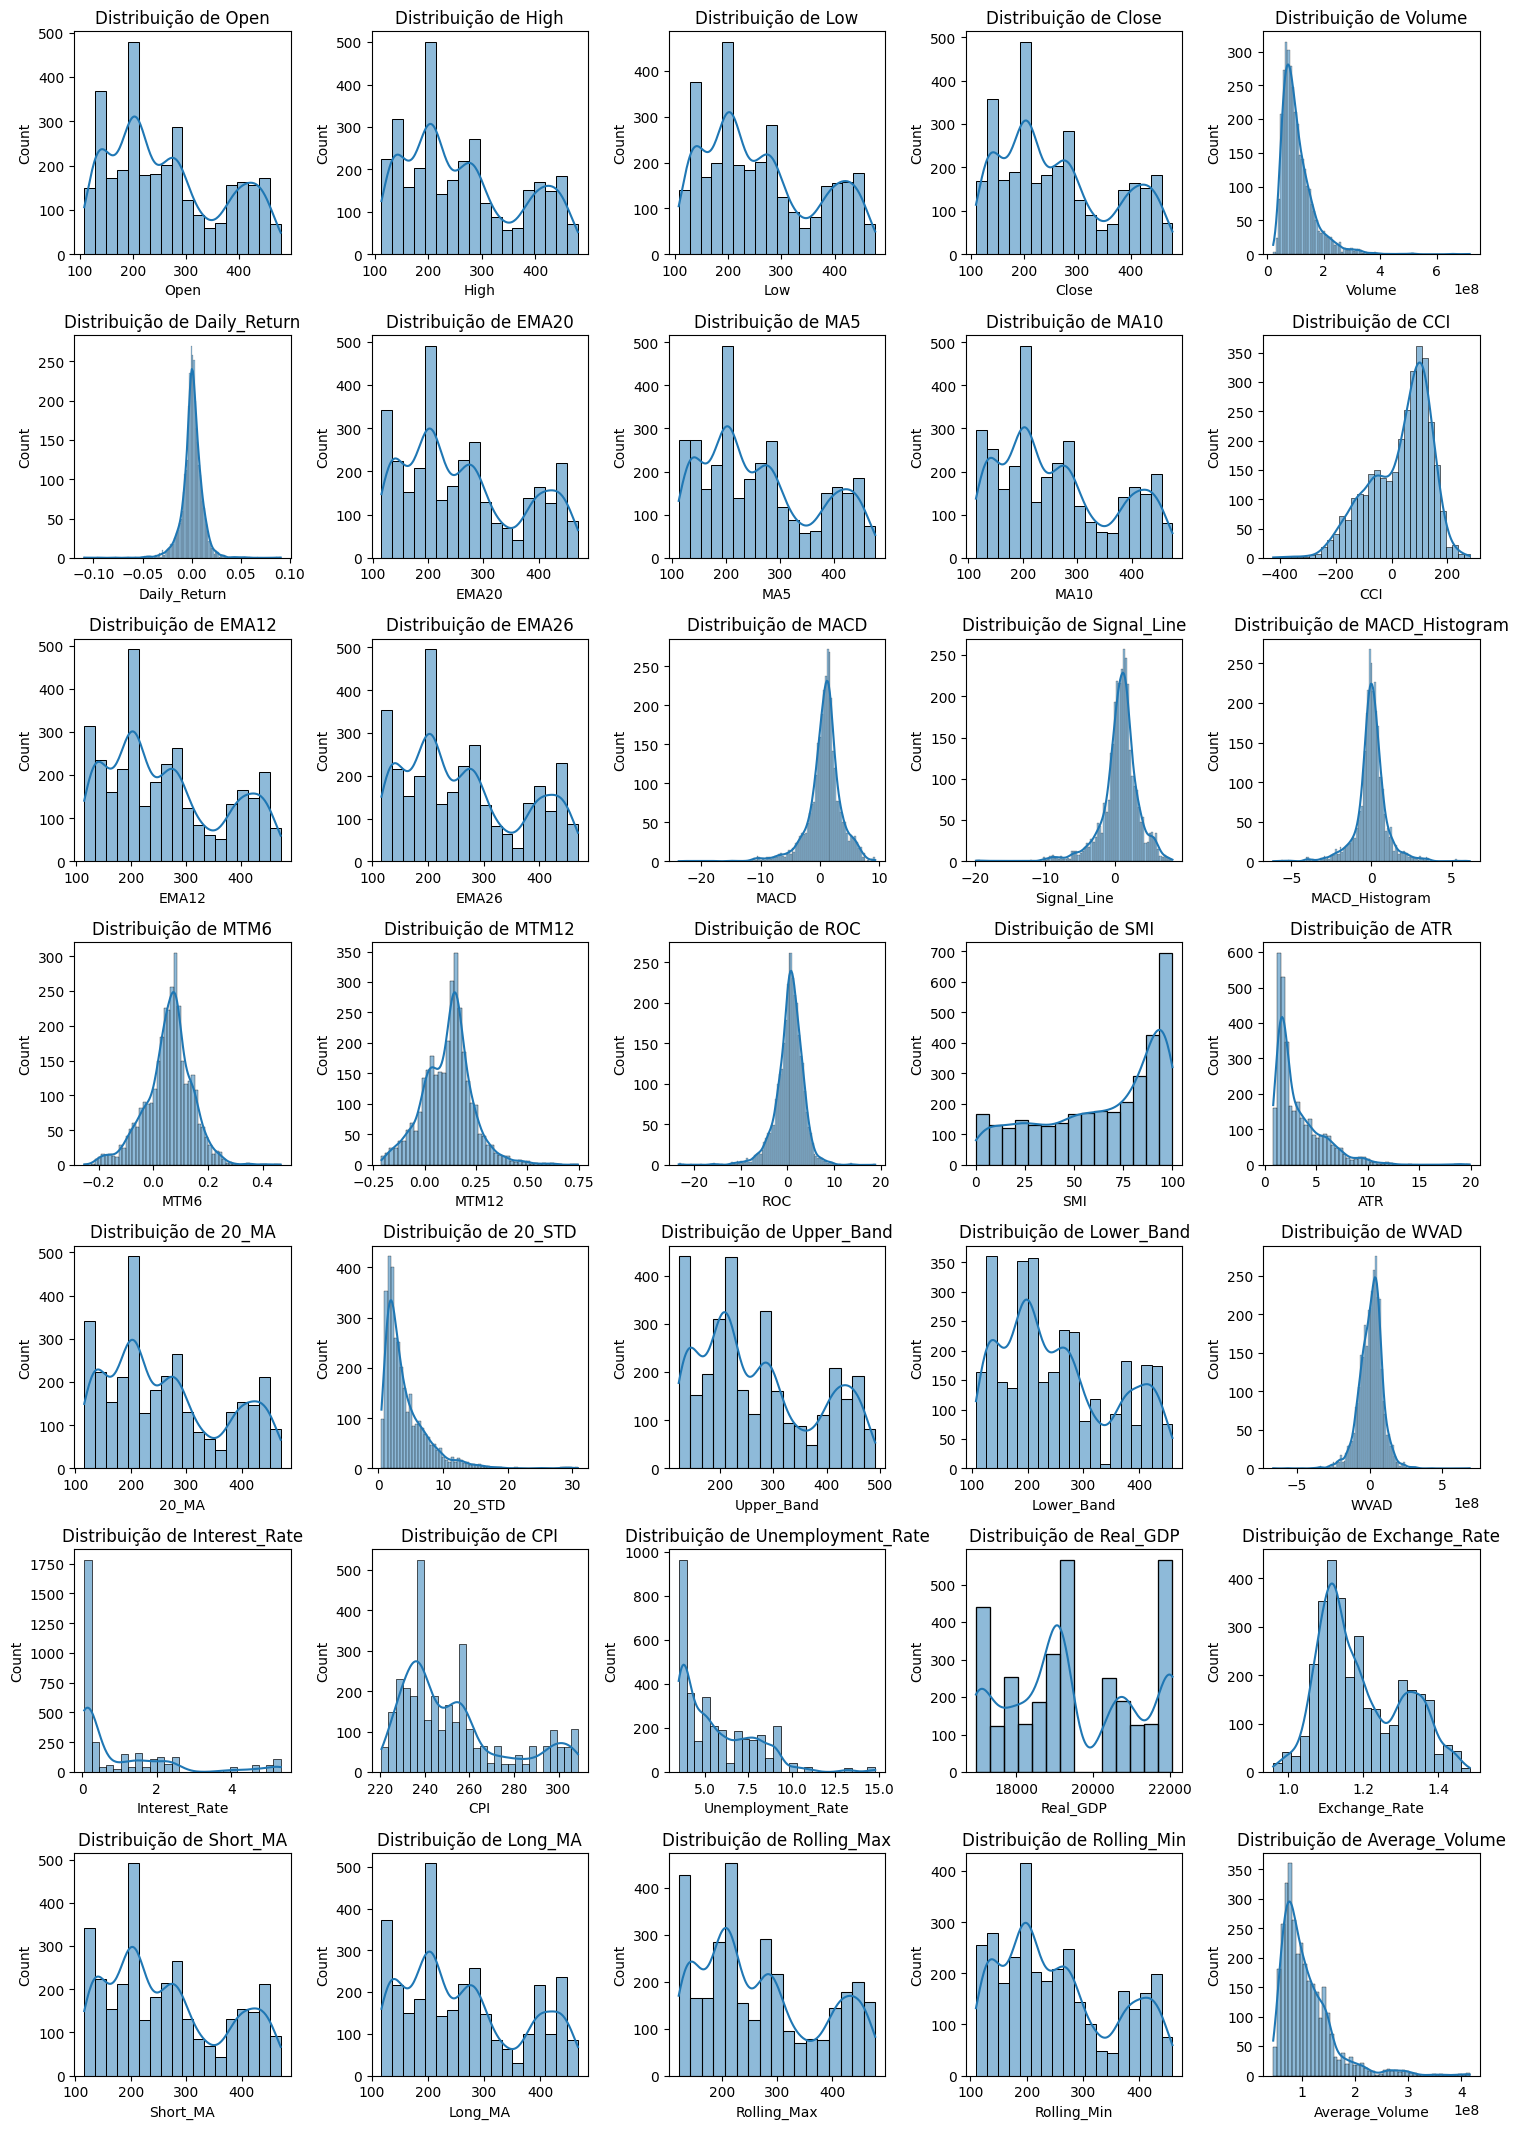

In [36]:
import seaborn as sns
# Verificar o número total de variáveis numéricas
num_columns = spy_data.select_dtypes(include=['float64', 'int64']).columns
total_vars = len(num_columns)

# Ajustar o layout do subplot conforme o número de variáveis
cols = 5  # Número de colunas
rows = (total_vars // cols) + 1  # Número de linhas, com uma linha extra para as variáveis restantes

plt.figure(figsize=(15, rows * 3))  # Ajuste o tamanho do gráfico conforme necessário
for i, col in enumerate(num_columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(spy_data[col], kde=True)
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()


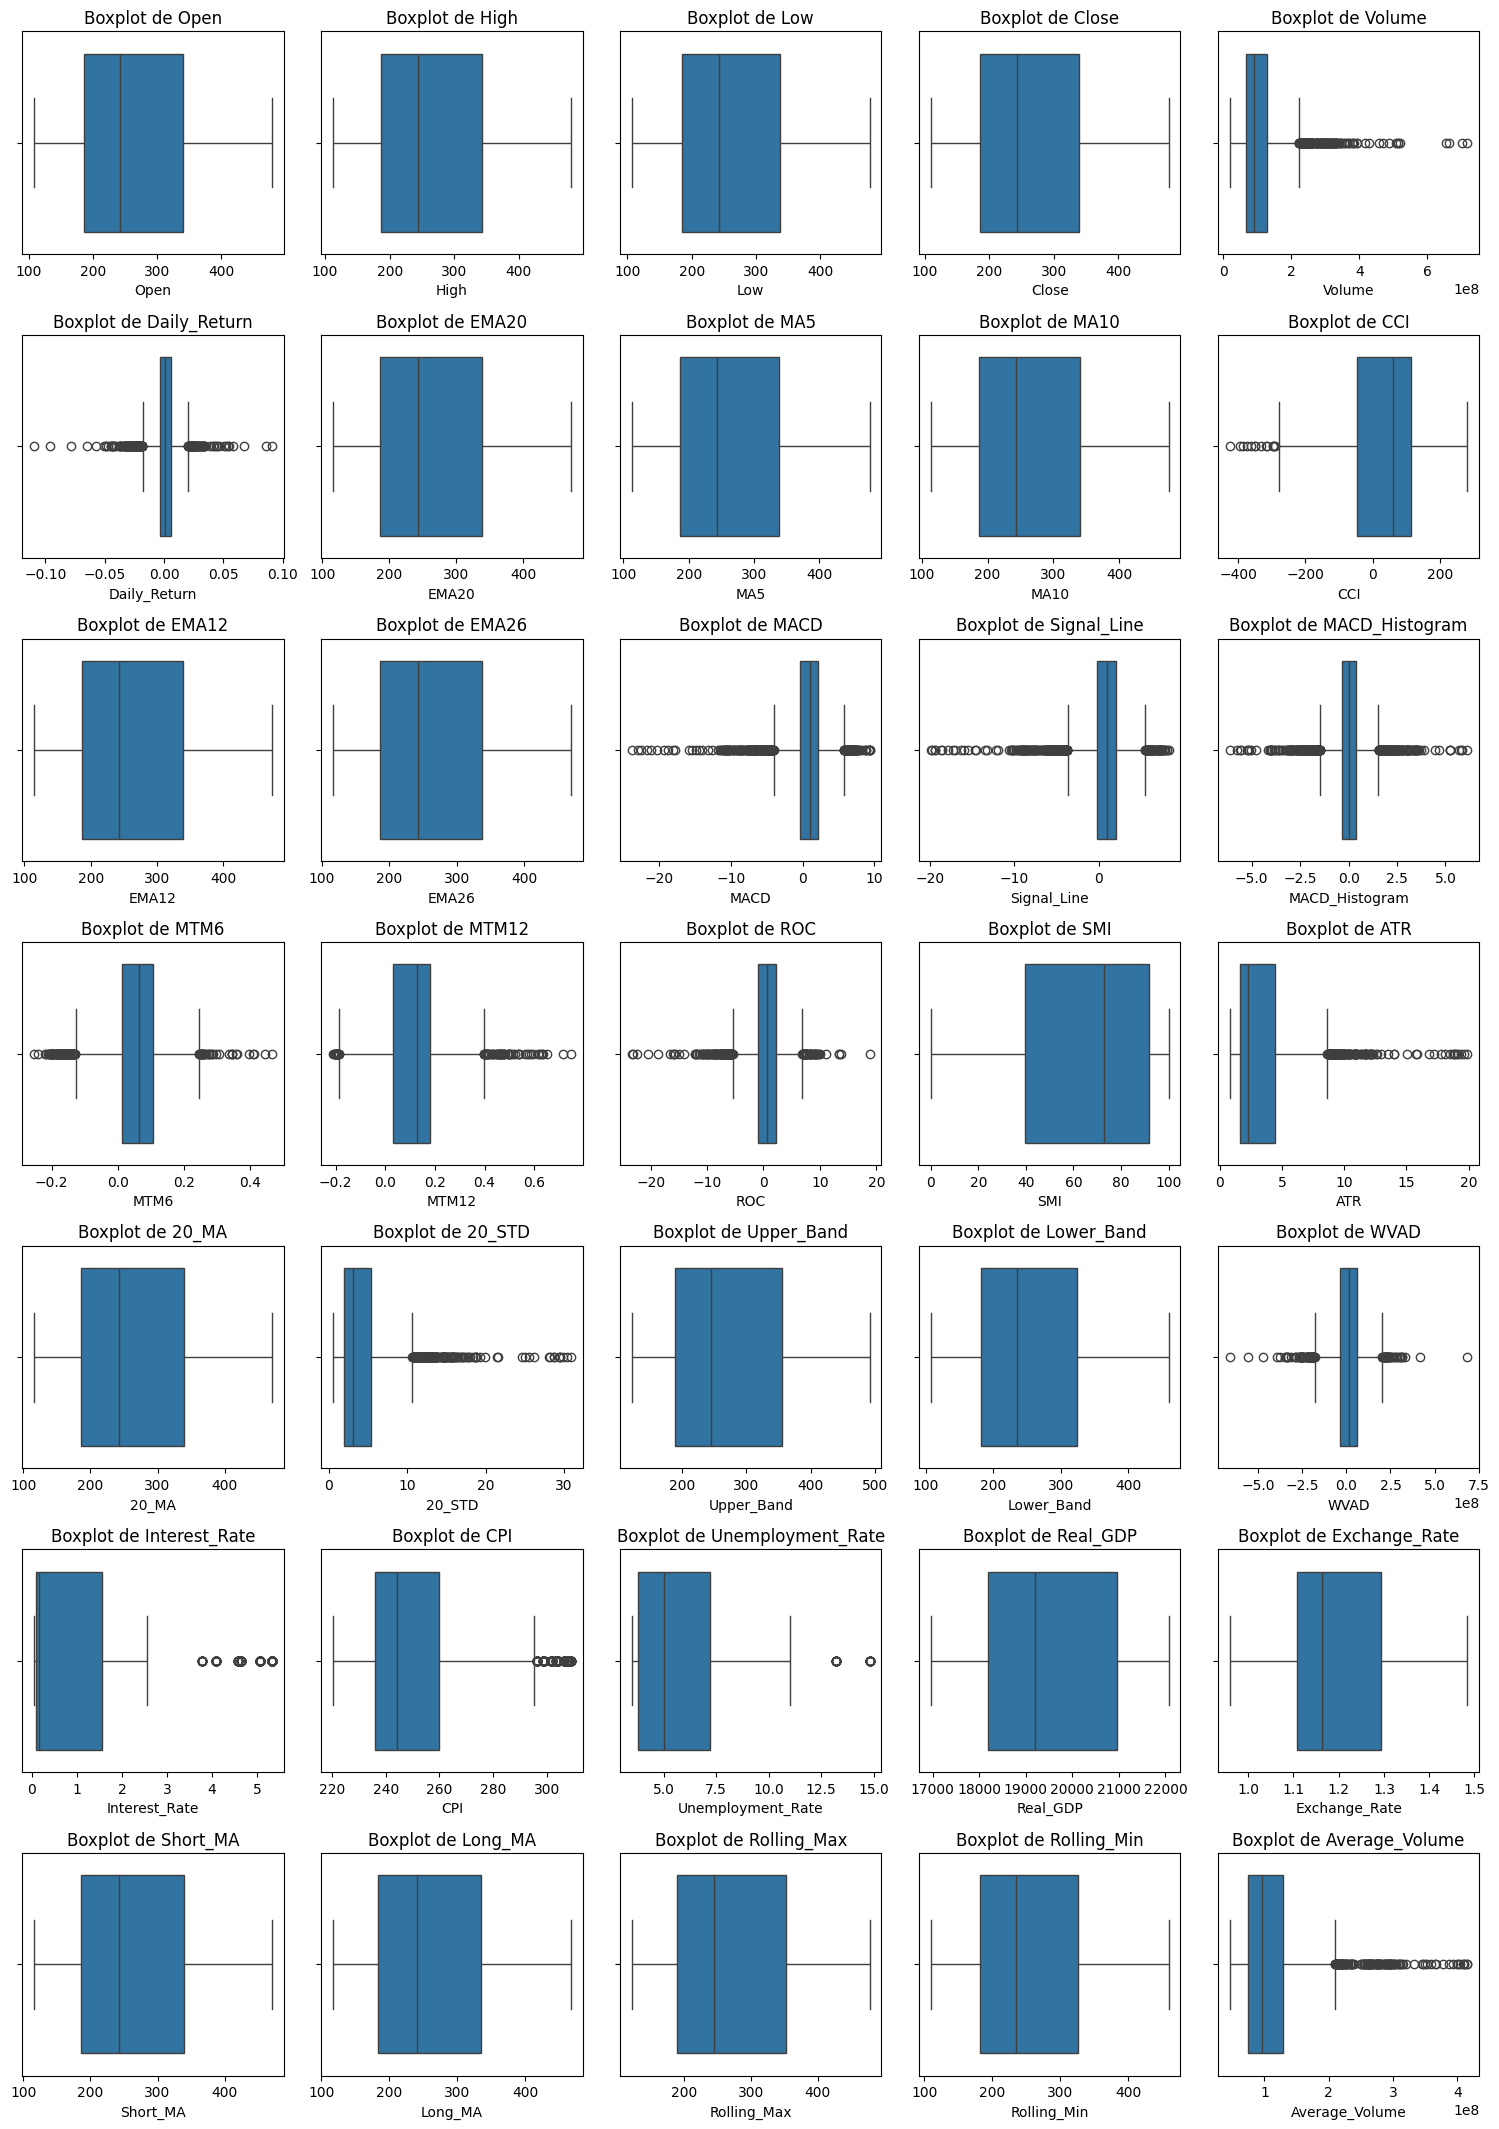

In [37]:
# Verificar o número total de variáveis numéricas
num_columns = spy_data.select_dtypes(include=['float64', 'int64']).columns
total_vars = len(num_columns)

# Ajustar o layout do subplot para acomodar todas as variáveis numéricas
cols = 5  # Número de colunas
rows = (total_vars // cols) + 1  # Número de linhas, com uma linha extra para as variáveis restantes

plt.figure(figsize=(15, rows * 3))  # Ajuste o tamanho da figura conforme necessário

# Criar o gráfico de boxplot para cada variável numérica
for i, col in enumerate(num_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=spy_data[col])
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


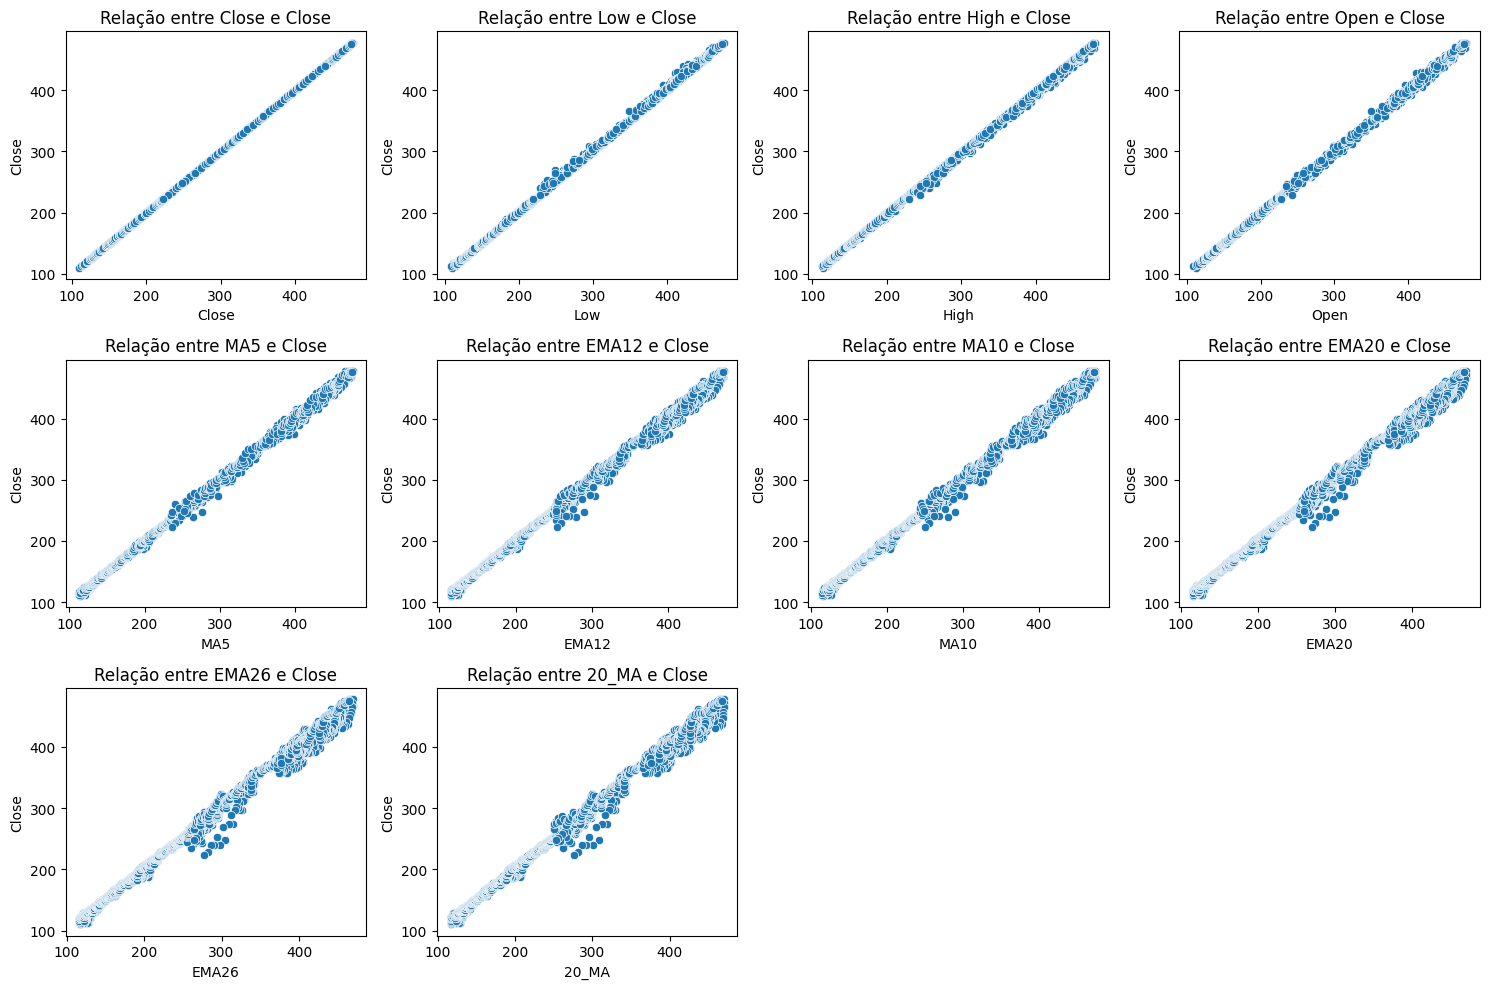

In [38]:
corr_matrix = spy_data.corr()
# Scatter plots para as variáveis mais correlacionadas com o Close
top_corr_features = corr_matrix['Close'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_corr_features, 1):
    plt.subplot(3, 4, i)  # Ajuste o layout conforme necessário
    sns.scatterplot(x=spy_data[feature], y=spy_data['Close'])
    plt.title(f'Relação entre {feature} e Close')
plt.tight_layout()
plt.show()


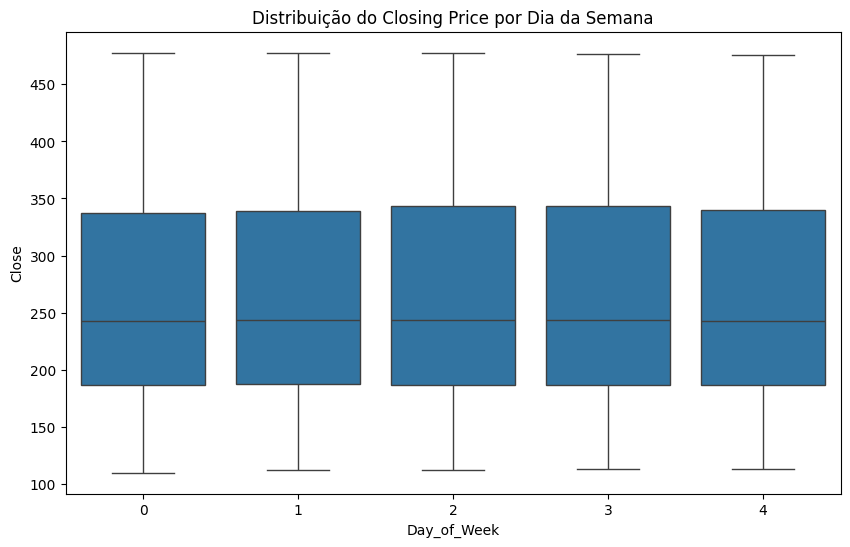

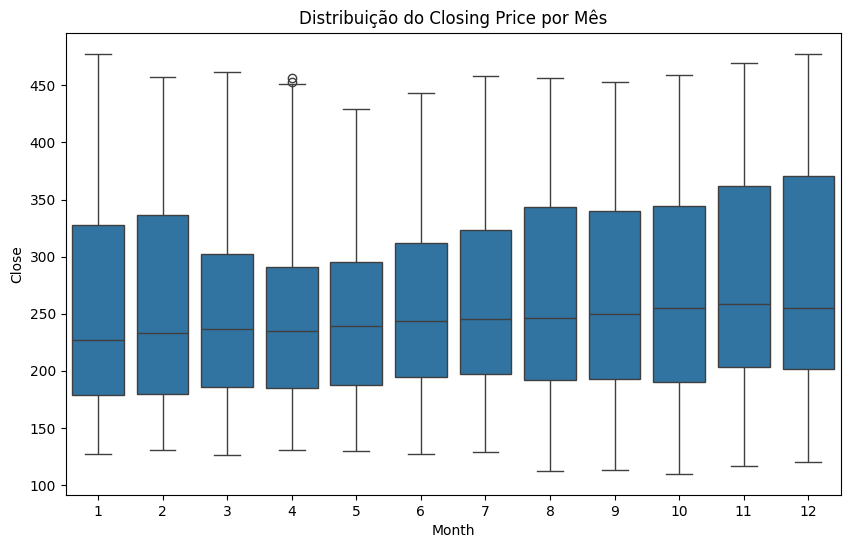

In [39]:
# Para a variável 'Day_of_Week'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_of_Week', y='Close', data=spy_data)
plt.title('Distribuição do Closing Price por Dia da Semana')
plt.show()

# Para a variável 'Month'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=spy_data)
plt.title('Distribuição do Closing Price por Mês')
plt.show()


C:\Users\utilizador\AppData\Local\Temp\ipykernel_21120\2489703967.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Wyckoff_Phase_Encoded', data=spy_data, palette='Set2')


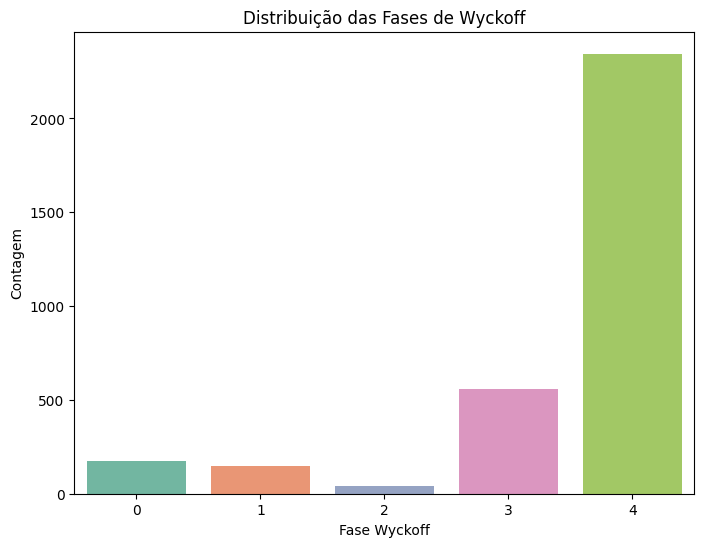

C:\Users\utilizador\AppData\Local\Temp\ipykernel_21120\2489703967.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Wyckoff_Phase_Encoded', y='Close', data=spy_data, palette='Set2')


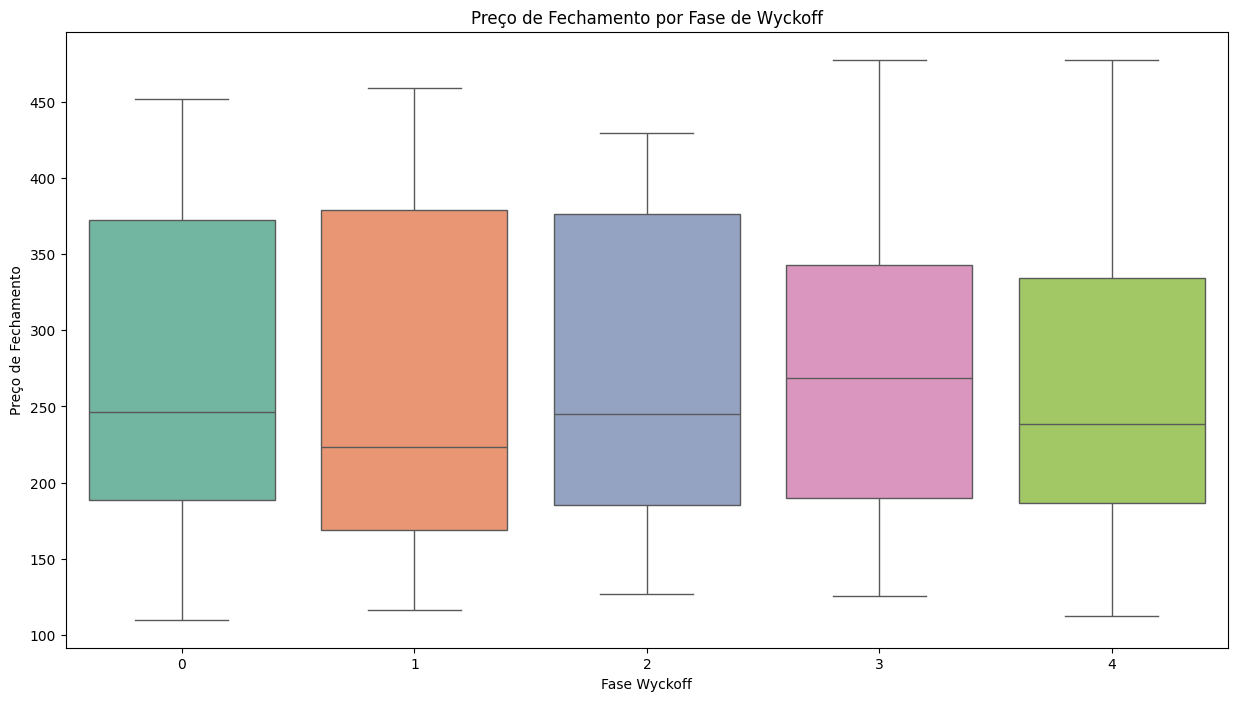

In [40]:
# Visualizar a distribuição de Wyckoff Phase
plt.figure(figsize=(8, 6))
sns.countplot(x='Wyckoff_Phase_Encoded', data=spy_data, palette='Set2')
plt.title('Distribuição das Fases de Wyckoff')
plt.xlabel('Fase Wyckoff')
plt.ylabel('Contagem')
plt.show()

# Relacionamento de Wyckoff com o Closing Price
plt.figure(figsize=(15, 8))
sns.boxplot(x='Wyckoff_Phase_Encoded', y='Close', data=spy_data, palette='Set2')
plt.title('Closing Price por Fase de Wyckoff')
plt.xlabel('Fase Wyckoff')
plt.ylabel('Closing Price')
plt.show()


In [41]:
from scipy.stats import shapiro

# Teste de Shapiro-Wilk para normalidade
for col in num_columns:
    stat, p_value = shapiro(spy_data[col].dropna())
    print(f'Teste de Shapiro-Wilk para {col}: estatística={stat:.3f}, p-valor={p_value:.3f}')


Teste de Shapiro-Wilk para Open: estatística=0.928, p-valor=0.000
Teste de Shapiro-Wilk para High: estatística=0.926, p-valor=0.000
Teste de Shapiro-Wilk para Low: estatística=0.929, p-valor=0.000
Teste de Shapiro-Wilk para Close: estatística=0.928, p-valor=0.000
Teste de Shapiro-Wilk para Volume: estatística=0.790, p-valor=0.000
Teste de Shapiro-Wilk para Daily_Return: estatística=0.899, p-valor=0.000
Teste de Shapiro-Wilk para EMA20: estatística=0.925, p-valor=0.000
Teste de Shapiro-Wilk para MA5: estatística=0.927, p-valor=0.000
Teste de Shapiro-Wilk para MA10: estatística=0.927, p-valor=0.000
Teste de Shapiro-Wilk para CCI: estatística=0.952, p-valor=0.000
Teste de Shapiro-Wilk para EMA12: estatística=0.926, p-valor=0.000
Teste de Shapiro-Wilk para EMA26: estatística=0.925, p-valor=0.000
Teste de Shapiro-Wilk para MACD: estatística=0.873, p-valor=0.000
Teste de Shapiro-Wilk para Signal_Line: estatística=0.875, p-valor=0.000
Teste de Shapiro-Wilk para MACD_Histogram: estatística=0.8

<Axes: xlabel='Month'>

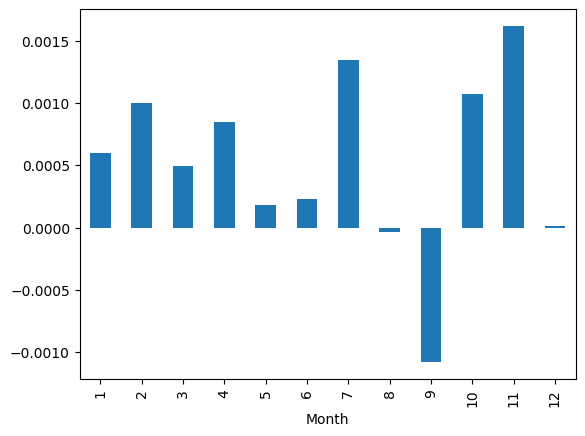

In [42]:
spy_data.groupby('Day_of_Week')['Daily_Return'].mean().plot(kind='bar')
spy_data.groupby('Month')['Daily_Return'].mean().plot(kind='bar')


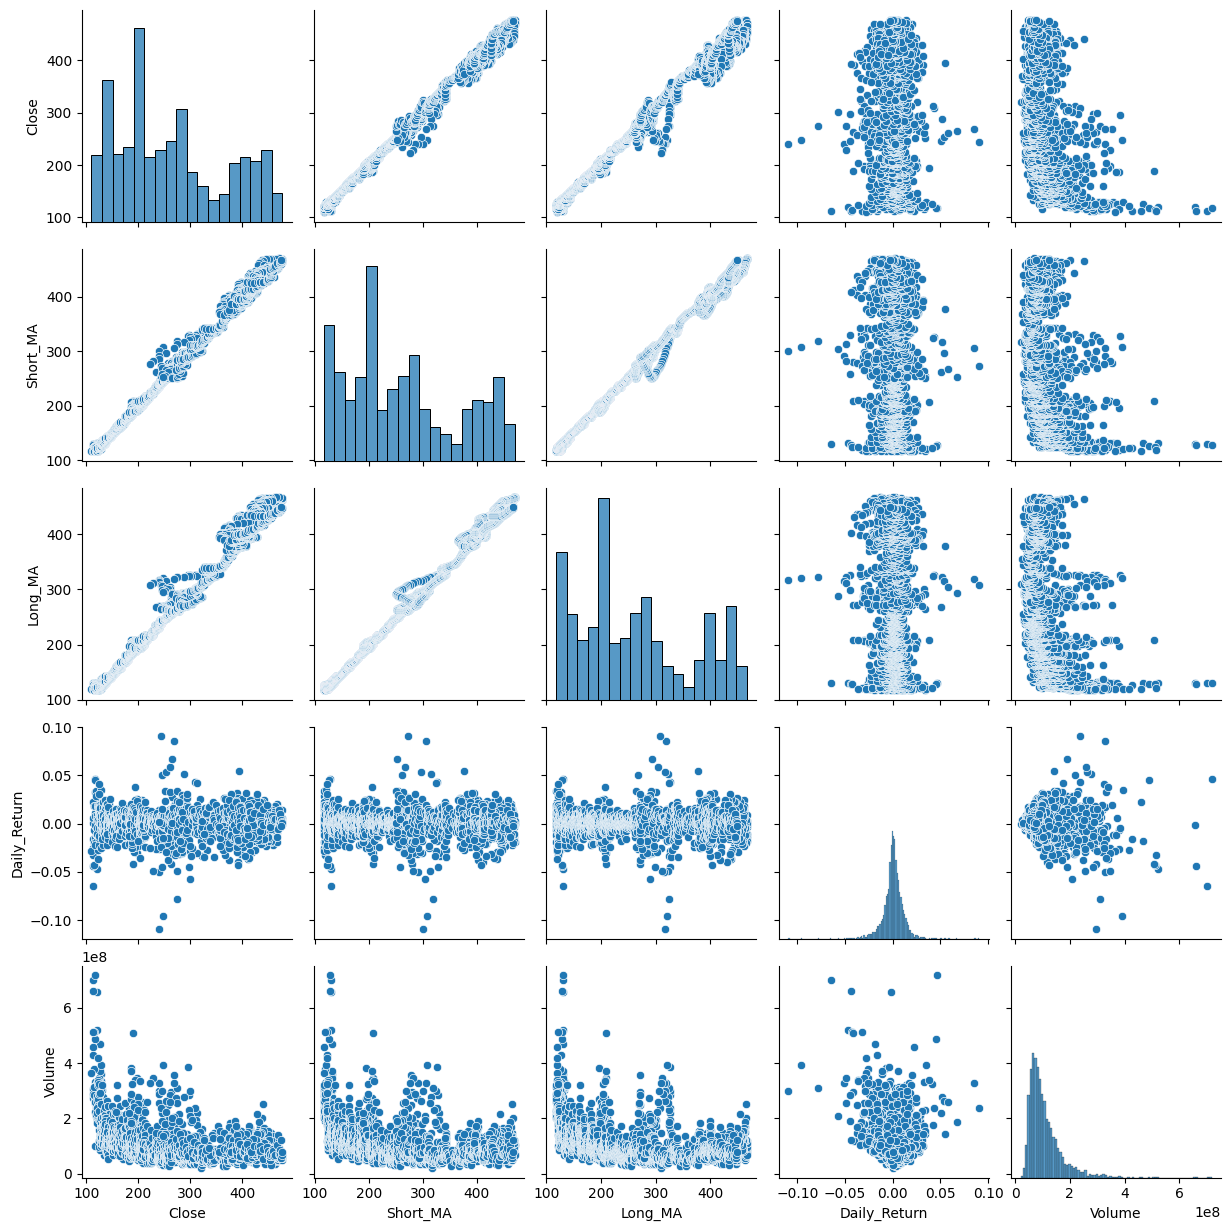

In [43]:
sns.pairplot(spy_data[['Close', 'Short_MA', 'Long_MA', 'Daily_Return', 'Volume']])


In [44]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    max_index = len(data) - time_steps
    for i in range(max_index):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `Close` (or target_column) for the next day (day 61)
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 20
target_column = 5 # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)


Shape of X: (3250, 20, 41)
Shape of y: (3250,)


In [45]:
print(spy_data.iloc[:, 5])

252     0.010338
253    -0.000551
254     0.005198
255    -0.001959
256    -0.001962
          ...   
3517    0.002010
3518    0.004223
3519    0.001808
3520    0.000378
3521   -0.002895
Name: Daily_Return, Length: 3270, dtype: float64


In [46]:
# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2600, 20, 41)
Shape of X_val: (650, 20, 41)
Shape of y_train: (2600,)
Shape of y_val: (650,)


In [47]:
def create_bidirectional_lstm(input_shape, units=64, dropout_rate=0.2):
    
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Bidirectional LSTM Layer
    model.add(LSTM(units, return_sequences=False))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.001  # Default for Adam is 0.001, adjust as needed
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [48]:
random.seed(42)

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6100 - mae: 0.6966 - val_loss: 0.2945 - val_mae: 0.4495
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2694 - mae: 0.4165 - val_loss: 0.1370 - val_mae: 0.2732
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1550 - mae: 0.2996 - val_loss: 0.0999 - val_mae: 0.2392
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1156 - mae: 0.2632 - val_loss: 0.0877 - val_mae: 0.2296
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0986 - mae: 0.2432 - val_loss: 0.0781 - val_mae: 0.2174
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0880 - mae: 0.2312 - val_loss: 0.0697 - val_mae: 0.2051
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0806 - mae: 0.2225 - val_loss: 0.0625 - val_mae: 0.1942
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0716 - mae: 0.2088 - val_loss: 0.0562 - val_mae: 0.1841
Epoch 9/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.06

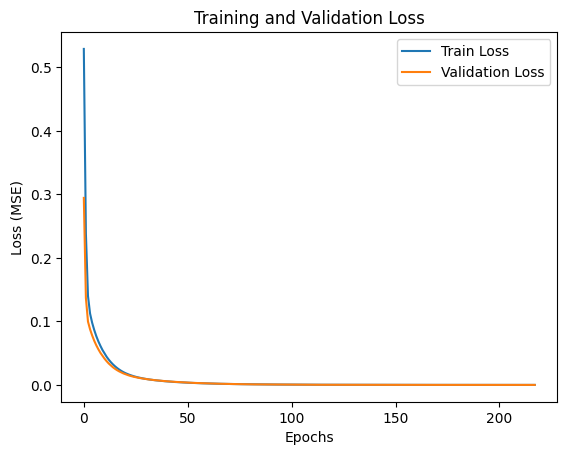

In [49]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # Adjust as needed
    batch_size=128,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [50]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for i in range (0,len(y_pred)):
    pred_return = y_pred[i]
    true_return = y_true[i]
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    five_day_return = true_return if position == 1 else 0
    #daily_return = true_return if position == 1 else 0
    strategy_returns.append(five_day_return)

    # Update cumulative return
    cumulative_return *= (1 + five_day_return)

# Convert strategy returns to a DataFrame for analysis
'''strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})'''

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Cumulative Return: 31.82%


In [51]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(1 + y_true) - 1  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")



True Buy-and-Hold Cumulative Return: 13.26%
Strategy Cumulative Return: 31.82%


In [52]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 50.77%
Mean of Predicted Returns: 0.00028787183691747487
Mean of Actual Returns: 0.00025686151521544625


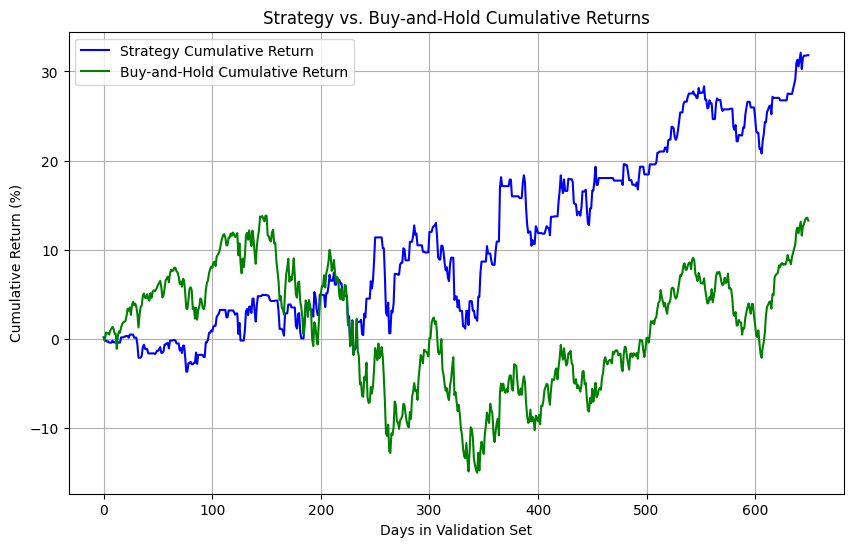

In [53]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

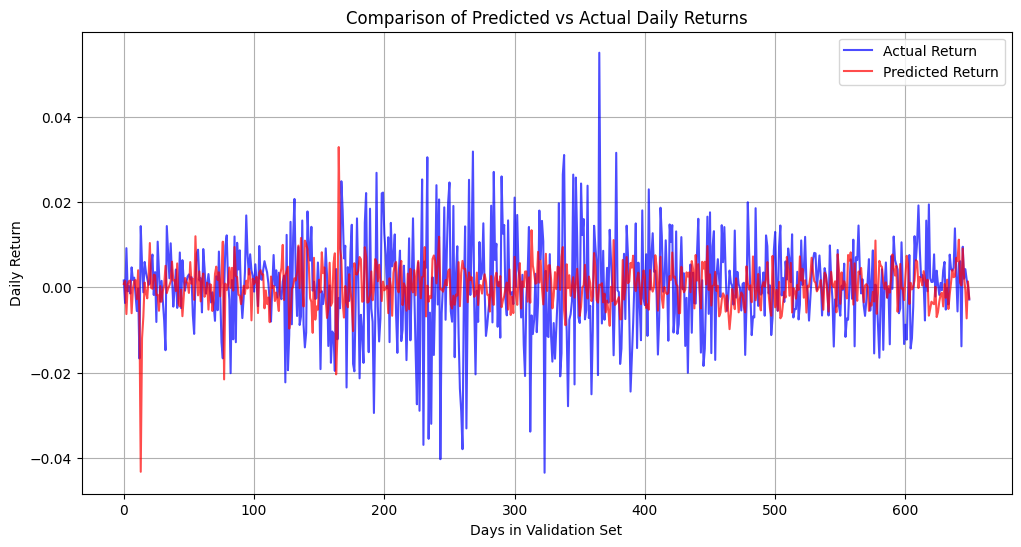

In [54]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()


Com normalização

In [55]:
from sklearn.preprocessing import StandardScaler

# Criar uma cópia do DataFrame original para normalizar
spy_data_norm = spy_data.copy()

# Selecionar apenas colunas numéricas contínuas para normalização
num_columns = spy_data_norm.select_dtypes(include=['float64', 'int64']).columns

# Se houver colunas que você sabe que não devem ser normalizadas, como variáveis categóricas ou de porcentagem, remova-as
# Por exemplo: 'Wyckoff_Phase_Encoded', 'Trend_Encoded', ou qualquer coluna categórica
num_columns = [col for col in num_columns if col not in ['Wyckoff_Phase_Encoded', 'Trend_Encoded']]

# Normalizar apenas as colunas numéricas contínuas
scaler = StandardScaler()
spy_data_norm[num_columns] = scaler.fit_transform(spy_data[num_columns])

# Verificar as primeiras linhas para confirmar que a normalização foi aplicada
print(spy_data.head())


         Open      High       Low     Close    Volume  Daily_Return  \
252 -1.330943 -1.327979 -1.334597 -1.327859  0.483672      0.903197   
253 -1.324929 -1.330196 -1.329811 -1.328538  0.462653     -0.093112   
254 -1.332204 -1.326823 -1.327175 -1.322137  0.407780      0.432869   
255 -1.321437 -1.325762 -1.321804 -1.324562  0.224737     -0.221910   
256 -1.322698 -1.326341 -1.330202 -1.326986  0.760233     -0.222262   

     Day_of_Week  Month     EMA20       MA5  ...  Exchange_Rate  Short_MA  \
252            0      1 -1.347988 -1.336899  ...       1.072802 -1.345802   
253            1      1 -1.345851 -1.334667  ...       1.047663 -1.343746   
254            2      1 -1.343305 -1.331327  ...       1.070484 -1.341403   
255            3      1 -1.341233 -1.328084  ...       1.080999 -1.339401   
256            4      1 -1.339590 -1.325385  ...       1.038435 -1.337754   

      Long_MA  Rolling_Max  Rolling_Min  Average_Volume  Volume_Spike  \
252 -1.366781    -1.344970    -1.3352

In [73]:
# Convert to NumPy array
data_norm = spy_data_norm.values
print("Dataset shape:", data_norm.shape)  # (num_days, num_features)
print(data_norm)


Dataset shape: (3270, 41)
[[-1.33094262 -1.32797932 -1.33459672 ...  1.          1.
   3.        ]
 [-1.32492867 -1.33019624 -1.32981145 ...  1.          2.
   4.        ]
 [-1.33220358 -1.32682261 -1.32717473 ...  1.          1.
   3.        ]
 ...
 [ 2.051695    2.03660509  2.07550457 ...  1.          1.
   3.        ]
 [ 2.06566284  2.04518363  2.0888836  ...  1.          1.
   3.        ]
 [ 2.06187975  2.04017146  2.05997677 ...  1.          2.
   4.        ]]


In [75]:
spy_data_norm.iloc[:, 5]

252     0.903197
253    -0.093112
254     0.432869
255    -0.221910
256    -0.222262
          ...   
3517    0.141181
3518    0.343649
3519    0.122734
3520   -0.008139
3521   -0.307583
Name: Daily_Return, Length: 3270, dtype: float64

In [76]:
# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 20
target_column = 5 # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data_norm, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)

Shape of X: (3250, 20, 41)
Shape of y: (3250,)


In [77]:
# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2600, 20, 41)
Shape of X_val: (650, 20, 41)
Shape of y_train: (2600,)
Shape of y_val: (650,)


Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0196 - mae: 0.6903 - val_loss: 1.1494 - val_mae: 0.8000
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0190 - mae: 0.6505 - val_loss: 1.1144 - val_mae: 0.7889
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0571 - mae: 0.6410 - val_loss: 1.1343 - val_mae: 0.7993
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8760 - mae: 0.6312 - val_loss: 1.1173 - val_mae: 0.7955
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8988 - mae: 0.6294 - val_loss: 1.1266 - val_mae: 0.8016
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8931 - mae: 0.6189 - val_loss: 1.1363 - val_mae: 0.8027
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0329 - mae: 0.6546 - val_loss: 1.1221 - val_mae: 0.8016
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0209 - mae: 0.7391 
Validation Loss (MSE): 1.1143893003463745
Validation MAE: 0.7889100313186646


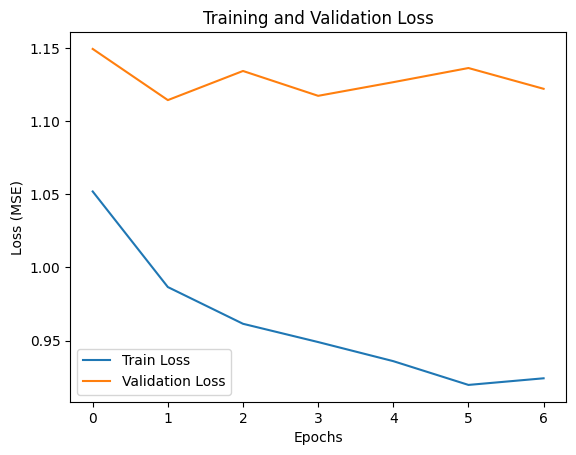

In [78]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # Adjust as needed
    batch_size=128,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [79]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for i in range (0,len(y_pred)):
    pred_return = y_pred[i]
    true_return = y_true[i]
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    five_day_return = true_return if position == 1 else 0
    #daily_return = true_return if position == 1 else 0
    strategy_returns.append(five_day_return)

    # Update cumulative return
    cumulative_return *= (1 + five_day_return)

# Convert strategy returns to a DataFrame for analysis
'''strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})'''

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Cumulative Return: -100.00%


In [61]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(1 + y_true) - 1  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")



True Buy-and-Hold Cumulative Return: -100.00%
Strategy Cumulative Return: -100.00%


In [62]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 48.46%
Mean of Predicted Returns: -0.17009277641773224
Mean of Actual Returns: 0.00025686151521544625


In [63]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 48.46%
Mean of Predicted Returns: -0.17009277641773224
Mean of Actual Returns: 0.00025686151521544625


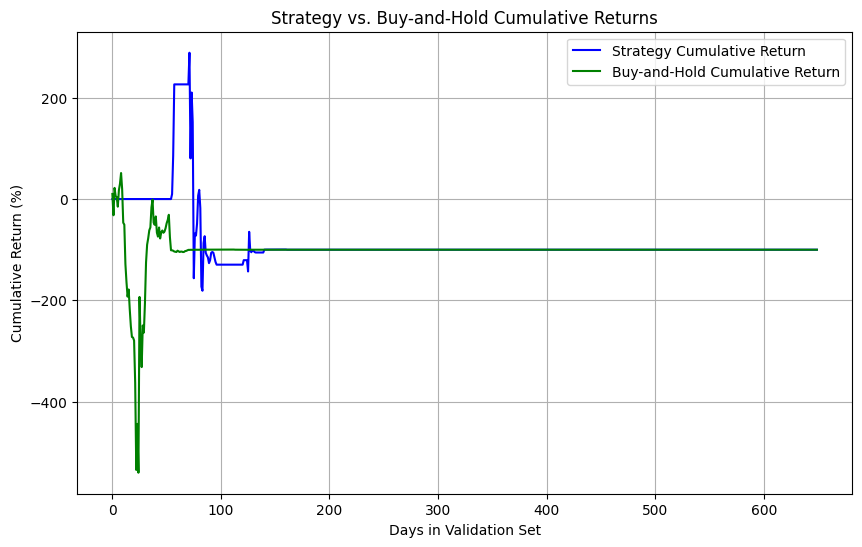

In [64]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()